In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_075_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.75))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3669 - acc: 0.2556
Epoch 00001: val_loss improved from inf to 2.15177, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_1_conv_checkpoint/001-2.1518.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.3669 - acc: 0.2556 - val_loss: 2.1518 - val_acc: 0.3557
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9174 - acc: 0.4260
Epoch 00002: val_loss improved from 2.15177 to 1.97358, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_1_conv_checkpoint/002-1.9736.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.9173 - acc: 0.4261 - val_loss: 1.9736 - val_acc: 0.4151
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5962 - acc: 0.5312
Epoch 00003: val_loss improved from 1.973

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0891 - acc: 0.9787
Epoch 00029: val_loss did not improve from 1.96512
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0891 - acc: 0.9788 - val_loss: 3.8391 - val_acc: 0.3771
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0771 - acc: 0.9828
Epoch 00030: val_loss did not improve from 1.96512
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0771 - acc: 0.9828 - val_loss: 3.8289 - val_acc: 0.3839
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0740 - acc: 0.9831
Epoch 00031: val_loss did not improve from 1.96512
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0740 - acc: 0.9831 - val_loss: 3.9091 - val_acc: 0.3869
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0705 - acc: 0.9849
Epoch 00032: val_loss did not improve from 1.96512
36805/36805 [===========

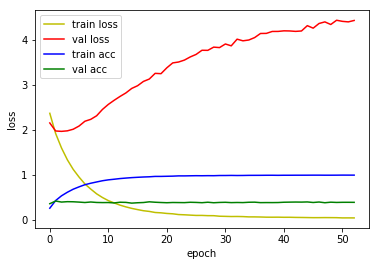

4815/4815 [==============================] - 2s 484us/sample - loss: 1.9901 - acc: 0.3761
Loss: 1.9900841282659354 Accuracy: 0.3761163

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2963 - acc: 0.2737
Epoch 00001: val_loss improved from inf to 2.04367, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_2_conv_checkpoint/001-2.0437.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.2962 - acc: 0.2737 - val_loss: 2.0437 - val_acc: 0.3823
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8893 - acc: 0.4253
Epoch 00002: val_loss improved from 2.04367 to 1.81009, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_2_conv_checkpoint/002-1.8101.hdf5
36805/36805 [==============================] - 72s 2ms/sample - loss: 1.8891 - acc: 0.4253 - val_loss: 1.8101 - val_acc: 0.4302
Epoch 3/500
36800/36805 [========================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1751 - acc: 0.9465
Epoch 00029: val_loss did not improve from 1.64045
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1750 - acc: 0.9466 - val_loss: 2.6729 - val_acc: 0.5155
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1668 - acc: 0.9493
Epoch 00030: val_loss did not improve from 1.64045
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1668 - acc: 0.9494 - val_loss: 2.6255 - val_acc: 0.5174
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1565 - acc: 0.9520
Epoch 00031: val_loss did not improve from 1.64045
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.1565 - acc: 0.9520 - val_loss: 2.6832 - val_acc: 0.5239
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1526 - acc: 0.9543
Epoch 00032: val_loss did not improve from 1.64045
36805/36805 [===========

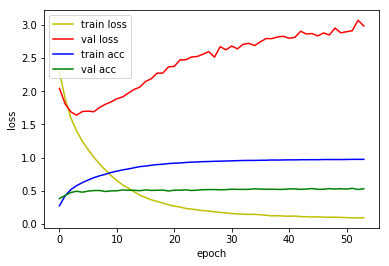

4815/4815 [==============================] - 4s 779us/sample - loss: 1.7036 - acc: 0.4652
Loss: 1.7035639770553368 Accuracy: 0.46521288

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3208 - acc: 0.2594
Epoch 00001: val_loss improved from inf to 1.92375, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_3_conv_checkpoint/001-1.9237.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.3209 - acc: 0.2594 - val_loss: 1.9237 - val_acc: 0.4235
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7208 - acc: 0.4714
Epoch 00002: val_loss improved from 1.92375 to 1.49081, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_3_conv_checkpoint/002-1.4908.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.7208 - acc: 0.4714 - val_loss: 1.4908 - val_acc: 0.5341
Epoch 3/500
36800/36805 [=======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2464 - acc: 0.9209
Epoch 00027: val_loss did not improve from 1.18870
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2464 - acc: 0.9209 - val_loss: 1.3834 - val_acc: 0.6883
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2376 - acc: 0.9238
Epoch 00028: val_loss did not improve from 1.18870
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2376 - acc: 0.9238 - val_loss: 1.4334 - val_acc: 0.6830
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2328 - acc: 0.9253
Epoch 00029: val_loss did not improve from 1.18870
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.2327 - acc: 0.9253 - val_loss: 1.4122 - val_acc: 0.6925
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2179 - acc: 0.9315
Epoch 00030: val_loss did not improve from 1.18870
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1223 - acc: 0.9620
Epoch 00057: val_loss did not improve from 1.18870
36805/36805 [==============================] - 81s 2ms/sample - loss: 0.1223 - acc: 0.9620 - val_loss: 1.4949 - val_acc: 0.7100

1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_3_conv Model


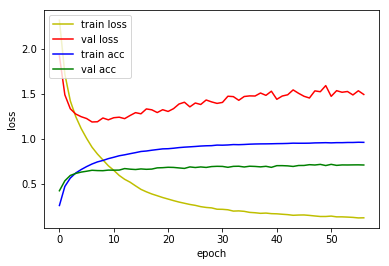

4815/4815 [==============================] - 4s 875us/sample - loss: 1.2764 - acc: 0.6183
Loss: 1.2764445521254653 Accuracy: 0.61827624

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2644 - acc: 0.2636
Epoch 00001: val_loss improved from inf to 1.60072, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_4_conv_checkpoint/001-1.6007.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.2643 - acc: 0.2636 - val_loss: 1.6007 - val_acc: 0.5041
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5548 - acc: 0.4996
Epoch 00002: val_loss improved from 1.60072 to 1.34620, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_4_conv_checkpoint/002-1.3462.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.5548 - acc: 0.4996 - val_loss: 1.3462 - val_acc: 0.5768
Epoch 3/500
36800/36805 [=======================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3781 - acc: 0.8755
Epoch 00025: val_loss did not improve from 0.78036
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3780 - acc: 0.8755 - val_loss: 0.8090 - val_acc: 0.7831
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3608 - acc: 0.8806
Epoch 00026: val_loss did not improve from 0.78036
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3607 - acc: 0.8806 - val_loss: 0.8470 - val_acc: 0.7780
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3537 - acc: 0.8843
Epoch 00027: val_loss did not improve from 0.78036
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.3537 - acc: 0.8843 - val_loss: 0.9135 - val_acc: 0.7619
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3431 - acc: 0.8865
Epoch 00028: val_loss did not improve from 0.78036
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2095 - acc: 0.9307
Epoch 00055: val_loss did not improve from 0.78036
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2095 - acc: 0.9306 - val_loss: 0.8505 - val_acc: 0.8078
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2112 - acc: 0.9319
Epoch 00056: val_loss did not improve from 0.78036
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2113 - acc: 0.9319 - val_loss: 0.8325 - val_acc: 0.8041
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2102 - acc: 0.9297
Epoch 00057: val_loss did not improve from 0.78036
36805/36805 [==============================] - 85s 2ms/sample - loss: 0.2101 - acc: 0.9297 - val_loss: 0.8891 - val_acc: 0.8099
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2101 - acc: 0.9296
Epoch 00058: val_loss did not improve from 0.78036
36805/36805 [===========

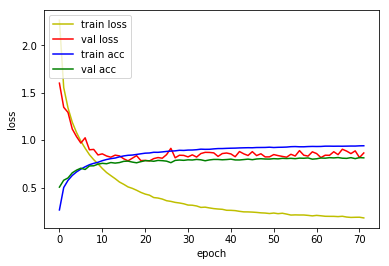

4815/4815 [==============================] - 4s 912us/sample - loss: 0.8678 - acc: 0.7526
Loss: 0.8677615195667508 Accuracy: 0.752648

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3058 - acc: 0.2465
Epoch 00001: val_loss improved from inf to 1.64343, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_5_conv_checkpoint/001-1.6434.hdf5
36805/36805 [==============================] - 92s 3ms/sample - loss: 2.3057 - acc: 0.2464 - val_loss: 1.6434 - val_acc: 0.4780
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5702 - acc: 0.4797
Epoch 00002: val_loss improved from 1.64343 to 1.42025, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_5_conv_checkpoint/002-1.4202.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.5704 - acc: 0.4797 - val_loss: 1.4202 - val_acc: 0.5497
Epoch 3/500
36800/36805 [=========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4004 - acc: 0.8767
Epoch 00024: val_loss did not improve from 0.54084
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.4003 - acc: 0.8767 - val_loss: 0.5423 - val_acc: 0.8546
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3863 - acc: 0.8793
Epoch 00025: val_loss did not improve from 0.54084
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3863 - acc: 0.8793 - val_loss: 0.5758 - val_acc: 0.8493
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3753 - acc: 0.8852
Epoch 00026: val_loss did not improve from 0.54084
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.3752 - acc: 0.8852 - val_loss: 0.5744 - val_acc: 0.8539
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3631 - acc: 0.8871
Epoch 00027: val_loss did not improve from 0.54084
36805/36805 [===========

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1983 - acc: 0.9362
Epoch 00053: val_loss did not improve from 0.52496
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1983 - acc: 0.9363 - val_loss: 0.5760 - val_acc: 0.8737
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1891 - acc: 0.9382
Epoch 00054: val_loss did not improve from 0.52496
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1891 - acc: 0.9382 - val_loss: 0.5293 - val_acc: 0.8786
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1885 - acc: 0.9383
Epoch 00055: val_loss did not improve from 0.52496
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1885 - acc: 0.9383 - val_loss: 0.5535 - val_acc: 0.8751
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1809 - acc: 0.9411
Epoch 00056: val_loss did not improve from 0.52496
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1275 - acc: 0.9596
Epoch 00083: val_loss did not improve from 0.52496
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1275 - acc: 0.9596 - val_loss: 0.5344 - val_acc: 0.8828
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1332 - acc: 0.9565
Epoch 00084: val_loss did not improve from 0.52496
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1331 - acc: 0.9566 - val_loss: 0.5342 - val_acc: 0.8884
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1338 - acc: 0.9570
Epoch 00085: val_loss did not improve from 0.52496
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.1338 - acc: 0.9570 - val_loss: 0.5352 - val_acc: 0.8821
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1263 - acc: 0.9597
Epoch 00086: val_loss did not improve from 0.52496
36805/36805 [===========

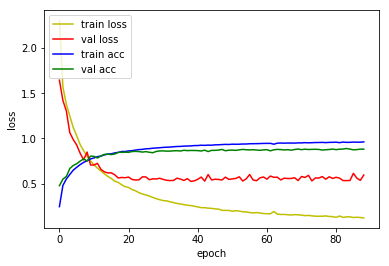

4815/4815 [==============================] - 5s 973us/sample - loss: 0.6535 - acc: 0.8226
Loss: 0.6535081007275131 Accuracy: 0.8226376

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4320 - acc: 0.1985
Epoch 00001: val_loss improved from inf to 1.68660, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv_checkpoint/001-1.6866.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 2.4319 - acc: 0.1985 - val_loss: 1.6866 - val_acc: 0.4582
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6466 - acc: 0.4561
Epoch 00002: val_loss improved from 1.68660 to 1.39801, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv_checkpoint/002-1.3980.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.6465 - acc: 0.4561 - val_loss: 1.3980 - val_acc: 0.5821
Epoch 3/500
36800/36805 [========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.4117 - acc: 0.8768
Epoch 00023: val_loss improved from 0.37333 to 0.36242, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv_checkpoint/023-0.3624.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.4116 - acc: 0.8768 - val_loss: 0.3624 - val_acc: 0.8968
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3886 - acc: 0.8835
Epoch 00024: val_loss did not improve from 0.36242
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3886 - acc: 0.8835 - val_loss: 0.3759 - val_acc: 0.8968
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3762 - acc: 0.8865
Epoch 00025: val_loss improved from 0.36242 to 0.35454, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv_checkpoint/025-0.3545.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.3761 - a

36800/36805 [============================>.] - ETA: 0s - loss: 0.2075 - acc: 0.9342
Epoch 00049: val_loss improved from 0.28333 to 0.28055, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv_checkpoint/049-0.2806.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.2075 - acc: 0.9342 - val_loss: 0.2806 - val_acc: 0.9294
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2021 - acc: 0.9353
Epoch 00050: val_loss did not improve from 0.28055
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.2020 - acc: 0.9353 - val_loss: 0.3261 - val_acc: 0.9222
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1971 - acc: 0.9364
Epoch 00051: val_loss improved from 0.28055 to 0.27129, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv_checkpoint/051-0.2713.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1971 - acc: 0.9364 - 

36800/36805 [============================>.] - ETA: 0s - loss: 0.1316 - acc: 0.9561
Epoch 00077: val_loss did not improve from 0.25886
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1316 - acc: 0.9561 - val_loss: 0.2795 - val_acc: 0.9315
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1259 - acc: 0.9585
Epoch 00078: val_loss did not improve from 0.25886
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1259 - acc: 0.9585 - val_loss: 0.2664 - val_acc: 0.9369
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1237 - acc: 0.9585
Epoch 00079: val_loss did not improve from 0.25886
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1237 - acc: 0.9585 - val_loss: 0.2878 - val_acc: 0.9331
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1226 - acc: 0.9604
Epoch 00080: val_loss did not improve from 0.25886
36805/36805 [========================

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0894 - acc: 0.9704
Epoch 00107: val_loss did not improve from 0.25886
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0893 - acc: 0.9704 - val_loss: 0.2818 - val_acc: 0.9399
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0915 - acc: 0.9694
Epoch 00108: val_loss did not improve from 0.25886
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0915 - acc: 0.9694 - val_loss: 0.3284 - val_acc: 0.9362

1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv Model


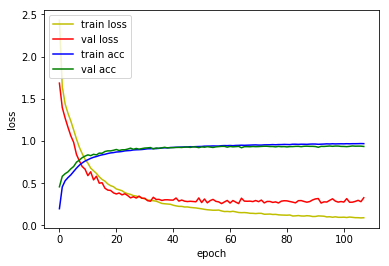

4815/4815 [==============================] - 5s 991us/sample - loss: 0.3041 - acc: 0.9107
Loss: 0.30411705678620937 Accuracy: 0.91069573

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6640 - acc: 0.1106
Epoch 00001: val_loss improved from inf to 2.32180, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_7_conv_checkpoint/001-2.3218.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.6640 - acc: 0.1106 - val_loss: 2.3218 - val_acc: 0.2457
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9710 - acc: 0.3494
Epoch 00002: val_loss improved from 2.32180 to 1.44424, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_7_conv_checkpoint/002-1.4442.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.9710 - acc: 0.3494 - val_loss: 1.4442 - val_acc: 0.5646
Epoch 3/500
36800/36805 [=====================

36800/36805 [============================>.] - ETA: 0s - loss: 0.3467 - acc: 0.8923
Epoch 00022: val_loss did not improve from 0.23577
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3466 - acc: 0.8923 - val_loss: 0.2466 - val_acc: 0.9304
Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3269 - acc: 0.8981
Epoch 00023: val_loss improved from 0.23577 to 0.23430, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_7_conv_checkpoint/023-0.2343.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3269 - acc: 0.8981 - val_loss: 0.2343 - val_acc: 0.9324
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.3133 - acc: 0.9026
Epoch 00024: val_loss improved from 0.23430 to 0.21775, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_7_conv_checkpoint/024-0.2177.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.3133 - acc: 0.9025 - 

Epoch 48/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1642 - acc: 0.9474
Epoch 00048: val_loss did not improve from 0.15181
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1642 - acc: 0.9474 - val_loss: 0.1774 - val_acc: 0.9522
Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1590 - acc: 0.9486
Epoch 00049: val_loss did not improve from 0.15181
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1590 - acc: 0.9486 - val_loss: 0.1662 - val_acc: 0.9529
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1576 - acc: 0.9488
Epoch 00050: val_loss did not improve from 0.15181
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1576 - acc: 0.9488 - val_loss: 0.1571 - val_acc: 0.9590
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1560 - acc: 0.9492
Epoch 00051: val_loss did not improve from 0.15181
36805/36805 [===========

Epoch 77/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0963 - acc: 0.9690
Epoch 00077: val_loss did not improve from 0.14146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0963 - acc: 0.9691 - val_loss: 0.1570 - val_acc: 0.9588
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0899 - acc: 0.9706
Epoch 00078: val_loss did not improve from 0.14146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0899 - acc: 0.9706 - val_loss: 0.1565 - val_acc: 0.9597
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0900 - acc: 0.9695
Epoch 00079: val_loss did not improve from 0.14146
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0900 - acc: 0.9695 - val_loss: 0.1579 - val_acc: 0.9592
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9690
Epoch 00080: val_loss did not improve from 0.14146
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0638 - acc: 0.9786
Epoch 00106: val_loss did not improve from 0.14096
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0638 - acc: 0.9786 - val_loss: 0.1741 - val_acc: 0.9639
Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0625 - acc: 0.9793
Epoch 00107: val_loss did not improve from 0.14096
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0626 - acc: 0.9792 - val_loss: 0.1805 - val_acc: 0.9602
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0627 - acc: 0.9798
Epoch 00108: val_loss did not improve from 0.14096
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0627 - acc: 0.9798 - val_loss: 0.1703 - val_acc: 0.9618
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0564 - acc: 0.9803
Epoch 00109: val_loss did not improve from 0.14096
36805/36805 [=====================

Epoch 136/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0457 - acc: 0.9847
Epoch 00136: val_loss did not improve from 0.14096
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0457 - acc: 0.9847 - val_loss: 0.1991 - val_acc: 0.9669
Epoch 137/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0453 - acc: 0.9857
Epoch 00137: val_loss did not improve from 0.14096
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0453 - acc: 0.9857 - val_loss: 0.1868 - val_acc: 0.9646
Epoch 138/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0438 - acc: 0.9850
Epoch 00138: val_loss did not improve from 0.14096
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0438 - acc: 0.9850 - val_loss: 0.1997 - val_acc: 0.9604
Epoch 139/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0408 - acc: 0.9864
Epoch 00139: val_loss did not improve from 0.14096
36805/36805 [=======

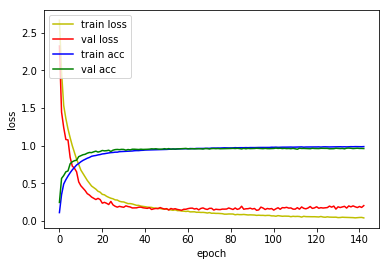

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1917 - acc: 0.9499
Loss: 0.19169405397580916 Accuracy: 0.9499481

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.6313 - acc: 0.1308
Epoch 00001: val_loss improved from inf to 2.23899, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_8_conv_checkpoint/001-2.2390.hdf5
36805/36805 [==============================] - 103s 3ms/sample - loss: 2.6314 - acc: 0.1308 - val_loss: 2.2390 - val_acc: 0.3035
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9980 - acc: 0.3387
Epoch 00002: val_loss improved from 2.23899 to 1.29258, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_8_conv_checkpoint/002-1.2926.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 1.9979 - acc: 0.3387 - val_loss: 1.2926 - val_acc: 0.5896
Epoch 3/500
36800/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.2671 - acc: 0.9178
Epoch 00023: val_loss improved from 0.15702 to 0.15590, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_8_conv_checkpoint/023-0.1559.hdf5
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2671 - acc: 0.9178 - val_loss: 0.1559 - val_acc: 0.9527
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2551 - acc: 0.9197
Epoch 00024: val_loss did not improve from 0.15590
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2550 - acc: 0.9197 - val_loss: 0.1573 - val_acc: 0.9550
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2483 - acc: 0.9232
Epoch 00025: val_loss did not improve from 0.15590
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.2483 - acc: 0.9232 - val_loss: 0.1780 - val_acc: 0.9488
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss:

Epoch 49/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1226 - acc: 0.9610
Epoch 00049: val_loss did not improve from 0.11014
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1226 - acc: 0.9610 - val_loss: 0.1173 - val_acc: 0.9655
Epoch 50/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1169 - acc: 0.9622
Epoch 00050: val_loss did not improve from 0.11014
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1169 - acc: 0.9622 - val_loss: 0.1141 - val_acc: 0.9683
Epoch 51/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1162 - acc: 0.9618
Epoch 00051: val_loss did not improve from 0.11014
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.1161 - acc: 0.9618 - val_loss: 0.1120 - val_acc: 0.9690
Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1150 - acc: 0.9620
Epoch 00052: val_loss did not improve from 0.11014
36805/36805 [===========

36800/36805 [============================>.] - ETA: 0s - loss: 0.0675 - acc: 0.9776
Epoch 00077: val_loss did not improve from 0.09989
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0675 - acc: 0.9776 - val_loss: 0.1180 - val_acc: 0.9697
Epoch 78/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0637 - acc: 0.9793
Epoch 00078: val_loss did not improve from 0.09989
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0637 - acc: 0.9793 - val_loss: 0.1359 - val_acc: 0.9697
Epoch 79/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0641 - acc: 0.9790
Epoch 00079: val_loss did not improve from 0.09989
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0641 - acc: 0.9790 - val_loss: 0.1297 - val_acc: 0.9658
Epoch 80/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0624 - acc: 0.9797
Epoch 00080: val_loss did not improve from 0.09989
36805/36805 [========================

Epoch 107/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0451 - acc: 0.9850
Epoch 00107: val_loss did not improve from 0.09989
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0451 - acc: 0.9850 - val_loss: 0.1383 - val_acc: 0.9709
Epoch 108/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0430 - acc: 0.9858
Epoch 00108: val_loss did not improve from 0.09989
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0430 - acc: 0.9858 - val_loss: 0.1575 - val_acc: 0.9706
Epoch 109/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0379 - acc: 0.9874
Epoch 00109: val_loss did not improve from 0.09989
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0379 - acc: 0.9874 - val_loss: 0.1443 - val_acc: 0.9716
Epoch 110/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0390 - acc: 0.9874
Epoch 00110: val_loss did not improve from 0.09989
36805/36805 [=======

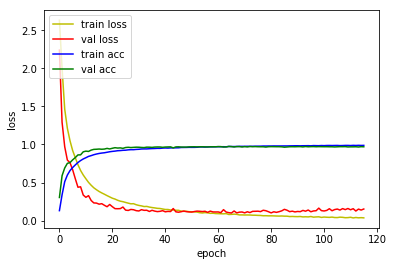

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.1385 - acc: 0.9610
Loss: 0.1385373390615296 Accuracy: 0.9609553

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.5069 - acc: 0.1788
Epoch 00001: val_loss improved from inf to 2.02420, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_9_conv_checkpoint/001-2.0242.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.5069 - acc: 0.1788 - val_loss: 2.0242 - val_acc: 0.3878
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.6843 - acc: 0.4560
Epoch 00002: val_loss improved from 2.02420 to 1.12097, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_9_conv_checkpoint/002-1.1210.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.6843 - acc: 0.4560 - val_loss: 1.1210 - val_acc: 0.6385
Epoch 3/500
36800/36805 [=========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1447 - acc: 0.9555
Epoch 00024: val_loss did not improve from 0.12844
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1447 - acc: 0.9555 - val_loss: 0.1285 - val_acc: 0.9597
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1414 - acc: 0.9542
Epoch 00025: val_loss did not improve from 0.12844
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1414 - acc: 0.9542 - val_loss: 0.1357 - val_acc: 0.9562
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1341 - acc: 0.9576
Epoch 00026: val_loss did not improve from 0.12844
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1341 - acc: 0.9576 - val_loss: 0.1384 - val_acc: 0.9595
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1299 - acc: 0.9588
Epoch 00027: val_loss improved from 0.12844 to 0.12749, saving model to mod

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0468 - acc: 0.9847
Epoch 00053: val_loss did not improve from 0.11623
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0468 - acc: 0.9847 - val_loss: 0.1714 - val_acc: 0.9604
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0510 - acc: 0.9830
Epoch 00054: val_loss did not improve from 0.11623
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0510 - acc: 0.9830 - val_loss: 0.1563 - val_acc: 0.9637
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0487 - acc: 0.9840
Epoch 00055: val_loss did not improve from 0.11623
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0487 - acc: 0.9841 - val_loss: 0.1272 - val_acc: 0.9693
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0459 - acc: 0.9847
Epoch 00056: val_loss did not improve from 0.11623
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0287 - acc: 0.9912
Epoch 00083: val_loss did not improve from 0.11623
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0287 - acc: 0.9912 - val_loss: 0.1746 - val_acc: 0.9676
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9914
Epoch 00084: val_loss did not improve from 0.11623
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0276 - acc: 0.9914 - val_loss: 0.1988 - val_acc: 0.9672
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0258 - acc: 0.9917
Epoch 00085: val_loss did not improve from 0.11623
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0258 - acc: 0.9917 - val_loss: 0.1594 - val_acc: 0.9674
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0260 - acc: 0.9921
Epoch 00086: val_loss did not improve from 0.11623
36805/36805 [===========

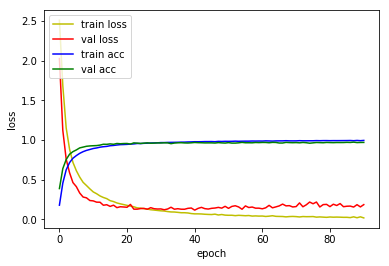

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1809 - acc: 0.9502
Loss: 0.18085583141063913 Accuracy: 0.95015574



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_075_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 615us/sample - loss: 1.9901 - 

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6535 - acc: 0.8226
Loss: 0.6535081007275131 Accuracy: 0.8226376

1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_124 (Conv1D)    

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.1385 - acc: 0.9610
Loss: 0.1385373390615296 Accuracy: 0.9609553

1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_166 (Conv1D)    

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_075_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_101 (Conv1D)     

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.3490 - acc: 0.9180
Loss: 0.34901009484166173 Accuracy: 0.9179647

1D_CNN_custom_conv_3_VGG_DO_075_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_136 (Conv1D)   

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.2721 - acc: 0.9572
Loss: 0.27214573371550027 Accuracy: 0.95721704
